# 流形学习manifold learning

- 用主成分分析降维——它可以在减少数据集特征的同时，保留数据点间的必要关系; 但是它对存在非线性关系的数据集的处理效果并不太好
- 流形学习是一种无监督评估器， 它试图将一个低维度流形嵌入到一个高维度空间来描述数据集

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1. 流形学习‘HELLO’

In [4]:
def make_hello(N=1000, rseed=42):
    # 画出hello文字形状的图像，并保存成png格式
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold',size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # 打开这个png,并将一些随机点画进去
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.12045654389686561,
 4.141801738018007,
 0.02705254376562046,
 1.0167333854408243)

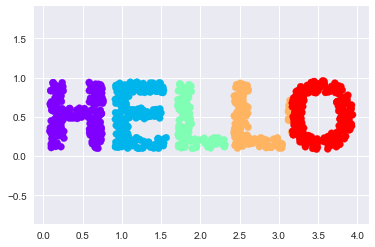

In [5]:
# 调用该函数，画出结果数据
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

## 2. 多维标度法

- 数据集中选中的 x 值和 y 值并不是对数据的最基本描述： 即使放大、 缩小或旋转数据，“HELLO”仍然会很明显。 
    - 例如， 如果用一个旋转矩阵来旋转数据，x 和 y 的值将会改变，但是数据形状基本还是一样的
        - 这说明 x 和 y 的值并不是数据间关系的必要基础特征。 
    - 这个例子中真正的基础特征是每个点与数据集中其他点的距离
        - 表示这种关系的常用方法是关系（距离）矩阵：对于N个点，构建一个N × N的矩阵， 元素 (i, j ) 是点i和点j之间的距离。

(4.59621603857608, 8.757400226754385, 5.018115494618391, 7.260978144218299)

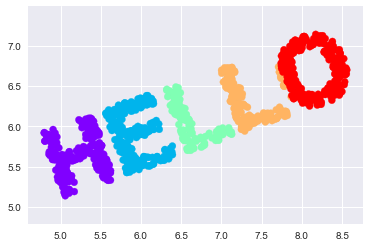

In [7]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')

(1000, 1000)


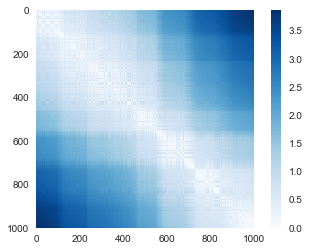

In [10]:
# 用 Scikit-Learn 中的pairwise_distances 函数来计算原始数据的关系矩阵
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
print(D.shape)

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [11]:
# 用类似方法为已经做过旋转和平移变换的数据构建一个距离矩阵，将看到同样的结果
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

- 虽然从 (x, y) 坐标计算这个距离矩阵很简单， 但是从距离矩阵转换回x 坐标值和 y 坐标值却非常困难。 这就是多维标度法可以解决的问题:
    - 它可以将一个数据集的距离矩阵还原成一个 D 维坐标来表示数据集
    - 如何还原距离矩阵: MDS 模型将非相似性（dissimilarity）参数设置为precomputed来处理距离矩阵

(-1.0406491825768218,
 1.0393561708003807,
 -2.0671954388580485,
 2.137987677891829)

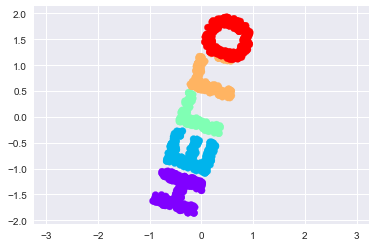

In [13]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

## 3. MDS用于流形学习

In [16]:
# 用以下函数将其投影到三维空间
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
print(X3.shape)

(1000, 3)


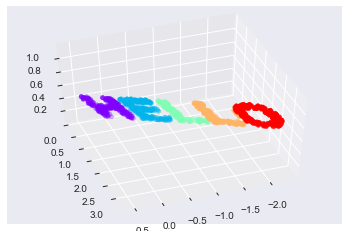

In [18]:
# 画出上面的点
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X3[:,0], X3[:,1], X3[:,2], **colorize)
ax.view_init(azim=70, elev=50)

- 现在可以通过 MDS 评估器输入这个三维数据， 计算距离矩阵， 然后得出距离矩阵的最优二维嵌入结果
    - 结果还原了原始数据的形状

(-1.0406491825768223,
 1.0393561708003816,
 -2.0671954388580467,
 2.1379876778918305)

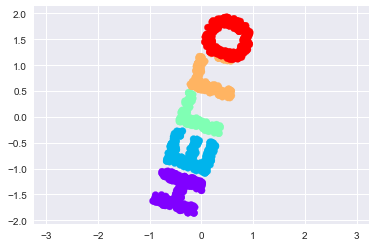

In [19]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

- 以上就是使用流形学习评估器希望达成的基本目标： 给定一个高维嵌入数据，寻找数据的一个低维表示，并保留数据间的特定关系。 
- 在 MDS的示例中，保留的数据是每对数据点之间的距离。

## 4. 非线性嵌入：当MSD失败时

- 线性嵌入模型， 它包括将数据旋转、 平移和缩放到一个高维空间的操作
- 但是当嵌入为非线性时， 即超越简单的操作集合时， MDS算法就会失效。

In [20]:
def make_hello_s_curve(X):
    t = (X[:,0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) -1)
    return np.vstack((x, y, z)).T

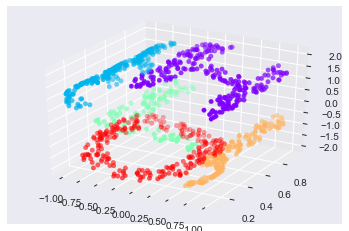

In [21]:
XS = make_hello_s_curve(X)
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(XS[:, 0], XS[:, 1], XS[:, 2],**colorize)

(-1.3920984041594926, 1.251006534654557, -2.388078851572826, 2.192515345762474)

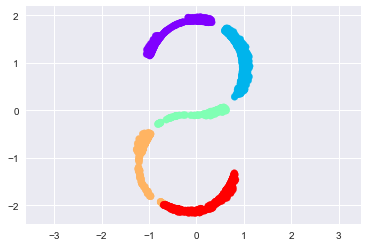

In [23]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

- 如果尝试用一个简单的 MDS 算法来处理这个数据， 就无法展示数据非线性嵌入的特征， 进而导致我们丢失了这个嵌入式流形的内部基本关系特性
- 即使是最优的二维线性嵌入也不能破解 S 曲线的谜题， 而且还丢失了原始数据的 y 轴信息

## 5. 非线性流形：局部线性嵌入

- MDS 算法生成的嵌入模型， 它会试图保留数据集中每对数据点间的距离
- 流形学习算法局部线性嵌入（LLE） 生成的嵌入模型， 该方法不保留所有的距离， 而是仅保留邻节点间的距离
    - 本例选择与每个点最近的 100 个邻节点
    - 这里用 modified LLE 算法来还原嵌入的二维流形
        - 通常情况下， modified LLE 的效果比用其他算法还原实现定义好的流形数据的效果好， 它几乎不会造成扭曲

(0.15, -0.15)

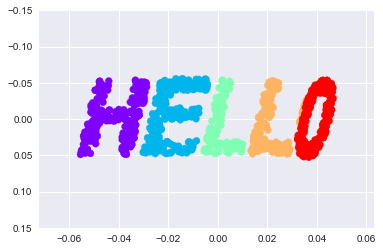

In [24]:
from sklearn.manifold import LocallyLinearEmbedding    # 局部线性嵌入（LLE）
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

## 6. 关于流形方法的一些思考

- 由于流形学习在实际应用中的要求非常严格， 因此除了在对高维数据进行简单的定性可视化之外， 流形学习很少被正式使用
- 以下是流形学习的一些挑战，并将其与PCA算法进行比较
    - 在流形学习中， 并没有好的框架来处理缺失值。 
        - 相比之下， PCA 算法中有一个用于处理缺失值的迭代方法
    - 在流形学习中， 数据中噪音的出现将造成流形“短路”， 并且严重影响嵌入结果
        - 相比之下， PCA 可以自然地从最重要的成分中滤除噪音
    - 流形嵌入的结果通常高度依赖于所选取的邻节点的个数， 并且通常没有确定的定量方式来选择最优的邻节点个数
        - 相比之下， PCA 算法中并不存在这样的问题
    - 在流形学习中， 全局最优的输出维度数很难确定
        - 相比之下， PCA可以基于解释方差来确定输出的维度数
    - 在流形学习中， 嵌入维度的含义并不总是很清楚
        - 而在 PCA 算法中， 主成分有非常明确的含义
    - 在流形学习中， 流形方法的计算复杂度为 O[N^2] 或 O[N^3]
        - 而 PCA可以选择随机方法， 通常速度更快
- 流形学习有一个明显的优点， 那就是它具有保留数据中的非线性关系的能力
    - 正因为这个原因， 我通常的做法是： 先用 PCA 探索数据的线性特征，再用流形方法探索数据的非线性特征

## 7. 案例：用Isomap用于处理人脸数据

- 流形学习经常被用于探索高维数据点内部的关系。 常见的高维数据就是图像数据

In [34]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.data.shape)   # (2370副图像, 每一副2914像素)
print(faces.images.shape)   # (2370, 62, 47)

(2370, 2914)
(2370, 62, 47)


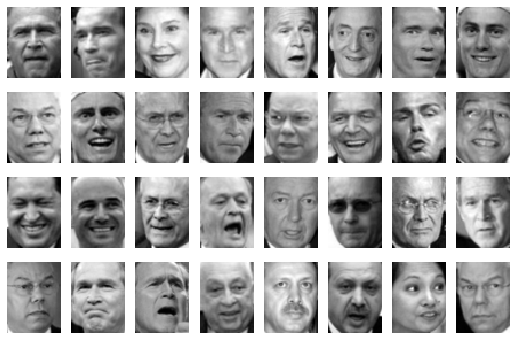

In [29]:
fig, ax = plt.subplots(4, 8, figsize=(9, 6), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

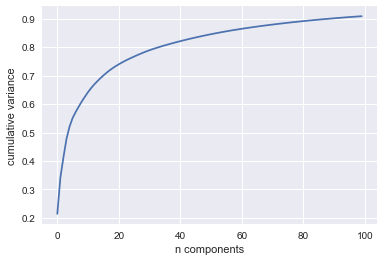

In [30]:
# 从计算 PCA 开始， 从而查看解释方差的比率。 通过这个比率， 就可以判断需要多少线性特征才能描述数据
from sklearn.decomposition import RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')


- 这个数据大约需要 100 个成分才能保存 90% 的方差， 说明该数据所需的维度非常高， 仅通过几个线性成分无法描述
- 由于存在上述问题， 因此非线性流形嵌入方法， 如 LLE 和 Isomap， 就可以派上用场了

In [31]:
# 用前面的方法对这些人脸数据计算一个 Isomap 嵌入
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [32]:
# 为了更好地理解该投影表示的含义， 来定义一个函数， 在不同的投影位置输出图像的缩略图
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0)))
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 不展示相距很近的点
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

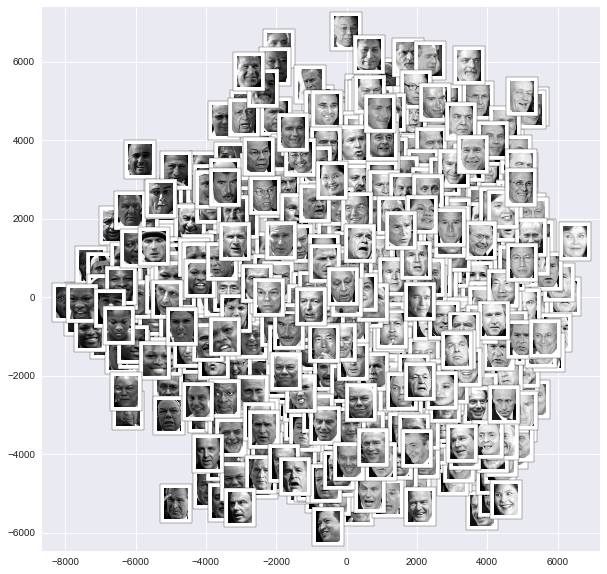

In [33]:
# 调用函数察看结果
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2])

- 前两个Isomap维度仿佛就描述了图像的整体特征：图像明暗度从左至右持续变化，人脸朝向从下到上持续变化。
- 我们可以根据这个结果将数据进行分类， 并像 5.7 节做过的那样， 用流形特征作为分类算法的输入数据

## 8. 案例：手写数字的可视化结构（输入无法导入）

In [11]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。